In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10


2024-04-07 16:27:45.548566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 16:27:45.548617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 16:27:45.550171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Split training data into training and validation sets
split = int(0.8 * len(x_train))
x_val = x_train[split:]
x_train = x_train[:split]


In [4]:
# Reshape the data
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Define the custom VAE layer
class VAELayer(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(VAELayer, self).__init__()
        self.latent_dim = latent_dim

    def build(self, input_shape):
        self.z_mean = self.add_weight(shape=(self.latent_dim,), initializer='zeros', trainable=True, name='z_mean')
        self.z_log_var = self.add_weight(shape=(self.latent_dim,), initializer='zeros', trainable=True, name='z_log_var')

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(tf.reduce_mean(kl_loss))

        return z

def build_cvae(latent_dim):
    # Encoder
    input_img = Input(shape=(32, 32, 3))
    input_label = Input(shape=(num_classes,))
    
    x = Conv2D(64, (3, 3), strides=2, padding="same")(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    # Sampling
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Decoder
  
    x = Dense(8*8*128)(z)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((8, 8, 128))(x)
    
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    output_img = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)

    # Define the model
    vae_out = CVAELayer(latent_dim)([output_img, input_img])
    vae = Model(input_img, vae_out)
    vae.compile(optimizer="adam")


Epoch 1/15
 13/625 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 117.1876

W0000 00:00:1712507504.020199    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712507504.023506    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13.0342

W0000 00:00:1712507511.946495    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 13.0187 - val_loss: 0.3525
Epoch 2/15
 17/625 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3240

W0000 00:00:1712507513.229597    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.3661 - val_loss: 0.2154
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.3218 - val_loss: 0.4176
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2197 - val_loss: 0.1615
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2167 - val_loss: 0.1478
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1378 - val_loss: 0.1248
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1253 - val_loss: 0.0927
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0971 - val_loss: 0.1126
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0990 - val_loss: 0.1018
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0999 - val_loss: 0.0916
Epoch 11/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0820 - val_loss: 0.0907
Epoch 12/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0927 - val_loss: 0.0825
Epoch 13/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/st

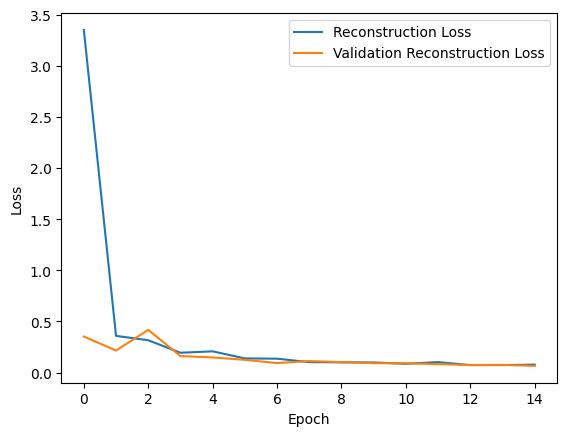

In [8]:
# Plot function
def plot_losses(history):
    plt.plot(history.history['loss'], label='Reconstruction Loss')
    plt.plot(history.history['val_loss'], label='Validation Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Training
latent_dim = 100
vae = build_vae(latent_dim)
vae.compile(optimizer='adam', loss="mse")

# Training loop with recording of KL divergence loss
epochs = 15
history = vae.fit(x_train, x_train, epochs=epochs, batch_size=64, validation_data=(x_val, x_val))

# Plot losses
plot_losses(history)

 75/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1712507616.154559    1769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


W0000 00:00:1712507617.543240    1768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


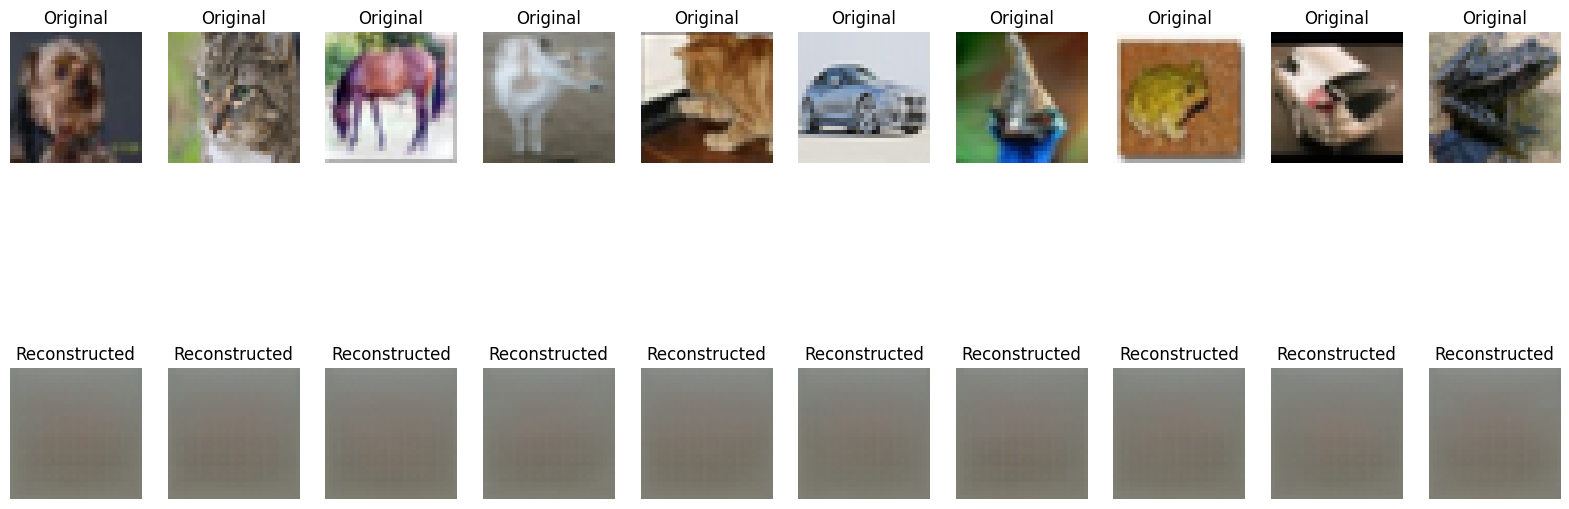

In [9]:
# Predict reconstructed images
reconstructed_images = vae.predict(x_test)

# Select 10 random indices
indices = np.random.randint(0, len(x_test), size=10)

# Plot original and reconstructed images
plt.figure(figsize=(20, 8))
for i, index in enumerate(indices):
    # Original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_val[index])
    plt.title('Original')
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[index])
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()


In [12]:
import numpy as np

# Function to calculate log likelihood
def calculate_log_likelihood(original_images, reconstructed_images):
    # Calculate mean squared error (MSE)
    mse = np.mean(np.square(original_images - reconstructed_images), axis=(1, 2, 3))
    
    # Calculate log likelihood assuming Gaussian distribution
    log_likelihood = -0.5 * (np.log(2 * np.pi) + np.log(mse))
    
    return log_likelihood

# Example usage:
# Assuming original_images and reconstructed_images are numpy arrays of shape (num_images, height, width, channels)

# Compute log likelihood
log_likelihood = calculate_log_likelihood(x_test, reconstructed_images)

# Print log likelihood
print("Log Likelihood:", log_likelihood)


Log Likelihood: [0.7092782  0.21953785 0.47112846 ... 0.17449379 0.544929   0.8052112 ]
